In [1]:
"""
 Copyright (c) 2021-2024 D-Robotics Corporation

 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

      http://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
"""

'\n Copyright (c) 2021-2024 D-Robotics Corporation\n\n Licensed under the Apache License, Version 2.0 (the "License");\n you may not use this file except in compliance with the License.\n You may obtain a copy of the License at\n\n      http://www.apache.org/licenses/LICENSE-2.0\n\n Unless required by applicable law or agreed to in writing, software\n distributed under the License is distributed on an "AS IS" BASIS,\n WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n See the License for the specific language governing permissions and\n limitations under the License.\n'

In [2]:
!cat /proc/meminfo | grep Mem

MemTotal:       17458624 kB
MemFree:         5400576 kB
MemAvailable:   10506688 kB


In [3]:
# import necessary package
import numpy as np
import cv2
import pyclipper
# import bpu_infer_lib
import matplotlib.pyplot as plt
import collections
from hobot_dnn import pyeasy_dnn
import libmodel_task

[UCP]: log level = 3
[UCP]: UCP version = 3.3.3
[VP]: log level = 3
[DNN]: log level = 3
[HPL]: log level = 3
[UCPT]: log level = 6
[DSP]: log level = 3


In [4]:
# load image function
def load_image(img_path):
    """Load an image from a file path."""
    img = cv2.imread(img_path)
    if img is None:
       print(f"Image file '{img_path}' not found.")
    return img

In [5]:
# load image
model_path = 'cn_PP-OCRv3_det_infer-deploy_640x640_nv12.hbm'
img_path = "gt_2322.jpg"
origin_img = load_image(img_path)

In [6]:
detection_model = pyeasy_dnn.load(model_path)
# if not detection_model.load_model(model_path):
#     print(f"Failed to load model from '{model_path}'.")

threshold = 0.5           # Threshold for binary classification
ratio_prime = 2.7         # Expansion ratio for the contour
input_size = (640, 640)   # Model input size

[BPU][[BPU_MONITOR]][281473495402176][INFO]BPULib verison(2, 1, 2)[0d3f195]!
[DNN] HBTL_EXT_DNN log level:6
[DNN]: 3.3.3_(4.1.17 HBRT)
2025/05/09 19:05:45.509 !INFO [prepare_model_tensor][1186]Preparing model tensors...

2025/05/09 19:05:45.509 !INFO [prepare_model_tensor][1187]Number of input tensors: 2

2025/05/09 19:05:45.509 !INFO [prepare_model_tensor][1188]Number of output tensors: 1

2025/05/09 19:05:45.509 !INFO [prepare_model_tensor][1289]Memory allocated for output tensor 0: 819200 bytes

2025/05/09 19:05:45.509 !INFO [prepare_model_tensor][1292]Model tensor preparation completed successfully.



In [7]:
def get_hw(pro):
    if pro.layout == "NCHW":
        return pro.shape[2], pro.shape[3]
    else:
        return pro.shape[1], pro.shape[2]

h, w = get_hw(detection_model[0].inputs[0].properties)
print(f"Model input size: {h}x{w}") 

Model input size: 640x640


In [8]:
def get_bounding_boxes(dilated_polys, min_area):
    """Get bounding boxes from dilated polygons."""
    boxes_list = []
    for cnt in dilated_polys:
        if cv2.contourArea(cnt) < min_area:
            continue
        rect = cv2.minAreaRect(cnt) # Calculate the minimum enclosing rectangle
        box = cv2.boxPoints(rect).astype(np.int_)
        boxes_list.append(box)
    return boxes_list

In [9]:

def dilate_contours(contours):
    """Dilate contours using the ratio_prime."""
    dilated_polys = []
    for poly in contours:
        poly = poly[:, 0, :]  # Extract the vertex coordinates of the polygon
        arc_length = cv2.arcLength(poly, True)  # Calculate the perimeter of the polygon
        if arc_length == 0:
            continue
        D_prime = (cv2.contourArea(poly) * ratio_prime / arc_length)  # Calculate the expansion amount D_prime


        pco = pyclipper.PyclipperOffset()
        pco.AddPath(poly, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
        dilated_poly = np.array(pco.Execute(D_prime))

        if dilated_poly.size == 0 or dilated_poly.dtype != np.int_ or len(dilated_poly) != 1:
                continue
        dilated_polys.append(dilated_poly)
    return dilated_polys

In [10]:
def resize_to_even(image):
    """
    Resize the image to ensure its width and height are even.
    
    Args:
        image (numpy.ndarray): Input image.
    
    Returns:
        numpy.ndarray: Resized image with even dimensions.
    """
    # height, width = image.shape[:2]
    # new_height = height if height % 2 == 0 else height - 1
    # new_width = width if width % 2 == 0 else width - 1
    resized_image = cv2.resize(image, (640, 640), interpolation=cv2.INTER_AREA)
    return resized_image
def bgr2nv12_opencv(image):
    height, width = image.shape[0], image.shape[1]
    area = height * width
    yuv420p = cv2.cvtColor(image, cv2.COLOR_BGR2YUV_I420).reshape((area * 3 // 2,))
    y = yuv420p[:area]
    uv_planar = yuv420p[area:].reshape((2, area // 4))
    uv_packed = uv_planar.transpose((1, 0)).reshape((area // 2,))

    nv12 = np.zeros_like(yuv420p)
    nv12[: height * width] = y
    nv12[height * width :] = uv_packed
    return nv12

In [11]:
# show image
def display_image(img, title="Image", figsize=(12, 8)):
    """Display an image using Matplotlib."""
    plt.figure(figsize=figsize) 
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

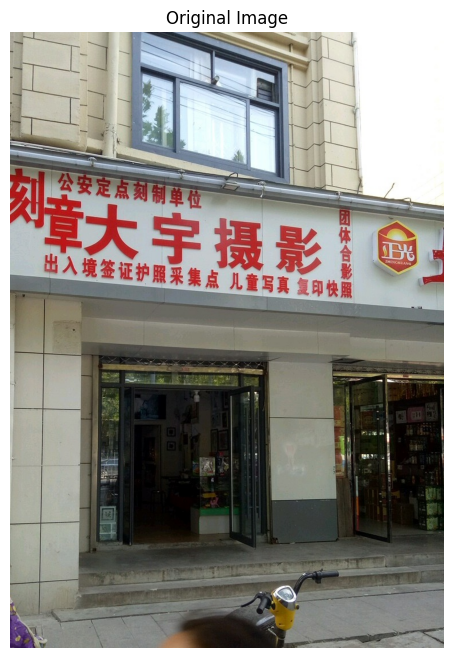

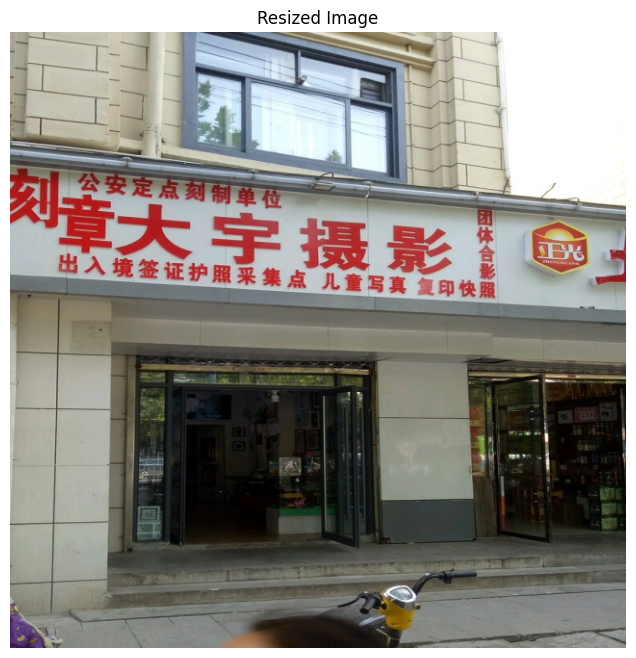

In [12]:
display_image(origin_img, "Original Image")
reshape_img = resize_to_even(origin_img)
display_image(reshape_img, "Resized Image")
nv12_image=bgr2nv12_opencv(reshape_img)
# display_image(nv12_image, "NV12 Image")

In [13]:
img_shape = origin_img.shape[:2]
print(img_shape)
        
outputs = detection_model[0].forward(nv12_image)
print(outputs[0].buffer)
preds = np.array(outputs[0].buffer, dtype=np.float32).reshape(1, *input_size)
preds = np.where(preds > threshold, 255, 0).astype(np.uint8).squeeze()
preds = cv2.resize(preds, (img_shape[1], img_shape[0]))
print(preds.shape) 
contours, _ = cv2.findContours(preds, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
dilated_polys = dilate_contours(contours)
boxes_list = get_bounding_boxes(dilated_polys, 100)
print(boxes_list)


(1080, 760)
[[[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]]
(1080, 760)
[array([[617, 749],
       [617, 739],
       [630, 739],
       [630, 749]]), array([[ 45, 431],
       [ 50, 375],
       [613, 426],
       [608, 483]]), array([[642, 405],
       [645, 358],
       [718, 364],
       [714, 411]]), array([[564, 308],
       [603, 307],
       [608, 438],
       [569, 439]]), array([[-40, 359],
       [ -8, 211],
       [580, 338],
       [548, 486]]), array([[ 69, 297],
       [ 75, 231],
       [357, 257],
       [351, 323]])]


In [14]:
# draw bounding box
def draw_bbox(img, bboxes, color=(128, 240, 128), thickness=3):
    img_copy = img.copy()
    for bbox in bboxes:
        bbox = bbox.astype(int)
        cv2.polylines(img_copy, [bbox], isClosed=True, color=color, thickness=thickness)
    return img_copy

In [15]:
img_boxes = draw_bbox(origin_img, boxes_list)
print(img_boxes.shape)

(1080, 760, 3)


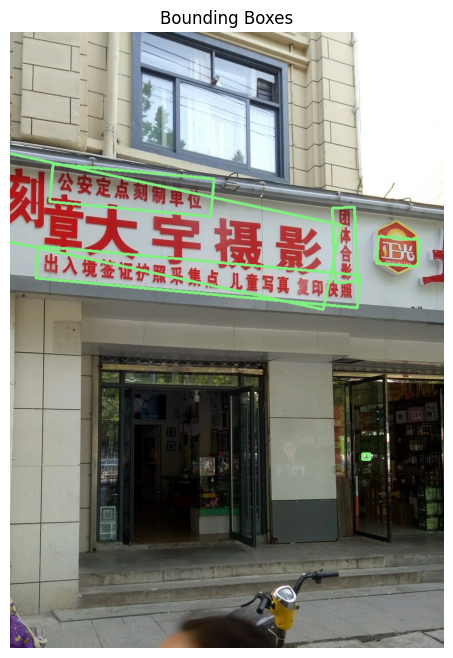

In [16]:
display_image(img_boxes, title="Bounding Boxes")

In [17]:
def crop_and_rotate_image(img, box):
    """Crop the image using the bounding box coordinates."""
    rect = cv2.minAreaRect(box) 
    box = cv2.boxPoints(rect).astype(np.intp)
    width = int(rect[1][0])
    height = int(rect[1][1])
    angle = rect[2]

    src_pts = box.astype("float32")
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]],
                        dtype="float32")

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img, M, (width, height))
    
    if angle >= 45:
        rotated = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
    else: 
        rotated = warped
    
    print("width:", rotated.shape[1], "height:", rotated.shape[0])
    
    return rotated

width: 13 height: 10


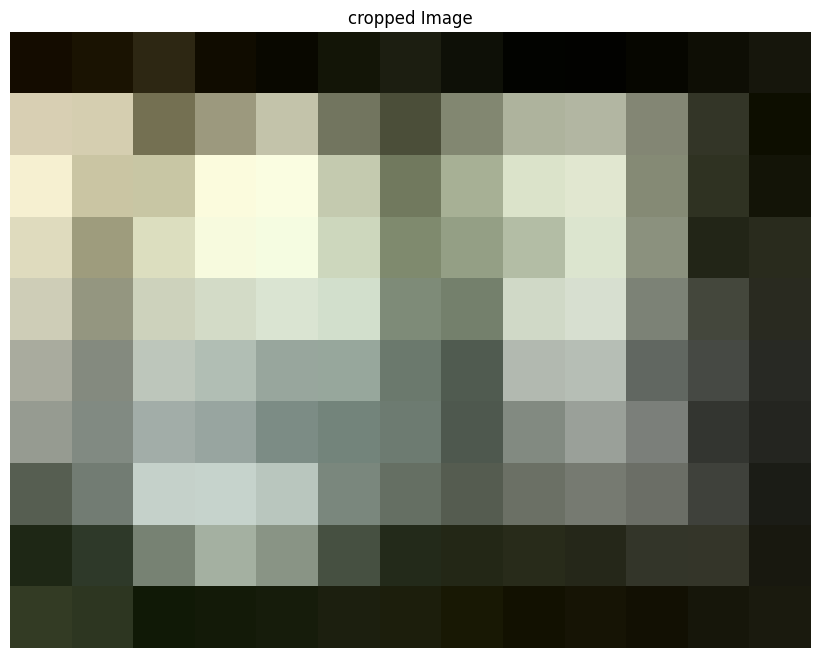

width: 565 height: 57


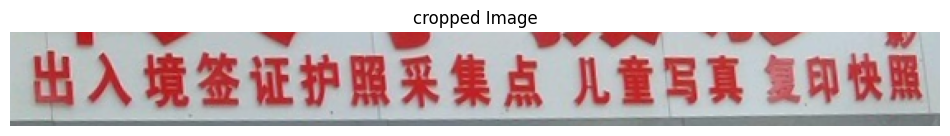

width: 73 height: 47


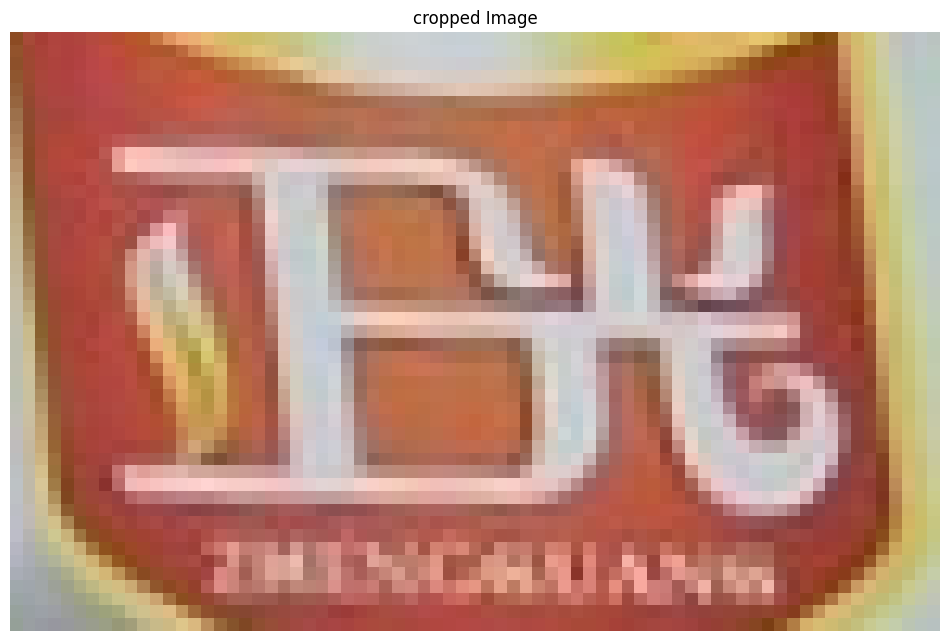

width: 39 height: 131


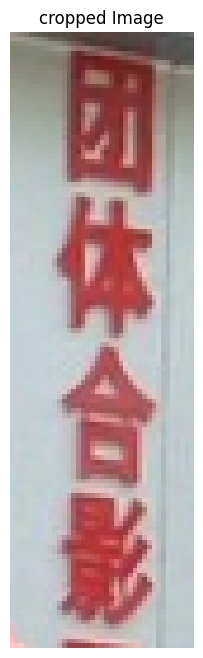

width: 601 height: 151


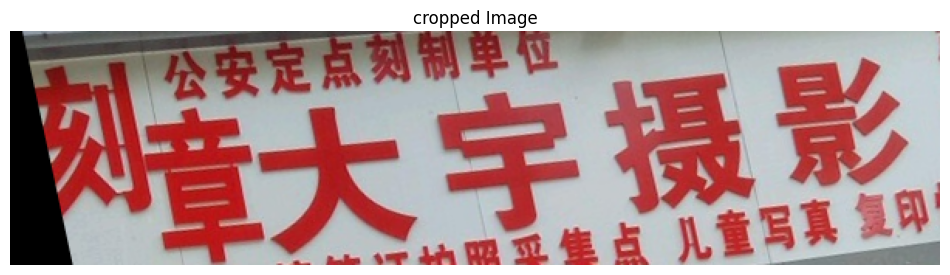

width: 283 height: 66


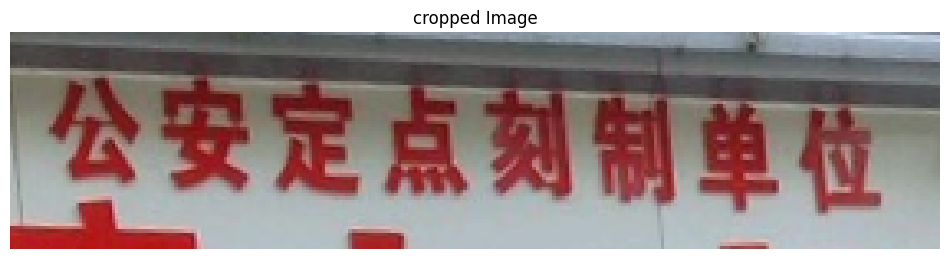

In [18]:
# Recognize text in each detected box
cropped_images = []

for i, box in enumerate(boxes_list):
    cropped_img = crop_and_rotate_image(origin_img, box)  # Crop the image using the bounding box
    cropped_images.append(cropped_img)  # Append the cropped image to the list
    display_image(cropped_img, title="cropped Image")

In [19]:
class strLabelConverter(object):
    """Convert between string and label for OCR tasks.

    Args:
        alphabet (str): Set of possible characters.
        ignore_case (bool, default=True): Whether to ignore case.
    """

    def __init__(self, alphabet, ignore_case=False):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1

    def encode(self, text):
        """Encode a string or a list of strings into a sequence of indices.

        Args:
            text (str or list of str): The text(s) to convert.

        Returns:
            np.array: Encoded text as an array of indices.
            np.array: Array of lengths for each text.
        """
        if isinstance(text, str):
            text = [
                self.dict[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (np.array(text, dtype=np.int32), np.array(length, dtype=np.int32))

    def decode(self, t, length, raw=False):
        """Decode a sequence of indices back into a string.

        Args:
            t (np.array): Encoded text as an array of indices.
            length (np.array): Array of lengths for each text.

        Raises:
            AssertionError: If the length of the text and the provided length do not match.

        Returns:
            str or list of str: Decoded text.
        """
        if len(length) == 1:
            length = length[0]
            assert len(t) == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t])
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return ''.join(char_list)
        else:
            # batch mode
            assert len(t) == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.size):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], np.array([l]), raw=raw))
                index += l
            return texts

In [20]:
alphabet = """0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~!"#$%&'()*+,-./  """
converter = strLabelConverter(alphabet)

In [21]:
def resize_norm_image(img, input_size):
    image_resized = cv2.resize(img, dsize=(input_size[1], input_size[0]))
    image_resized = (image_resized / 255.0).astype(np.float32)
    input_image = np.zeros((image_resized.shape[0], image_resized.shape[1], 3), dtype=np.float32)
    input_image[:image_resized.shape[0], :image_resized.shape[1], :] = image_resized
    input_image = image_resized[:, :, [2, 1, 0]]  # bgr->rgb
    input_image = input_image[None].transpose(0, 3, 1, 2) # NHWC -> HCHW
    
    return input_image

In [22]:
from postprocess.rec_postprocess import CTCLabelDecode
postprocess_op=CTCLabelDecode("ppocr_keys_v1.txt")

def rec_predict(input_image, model, output_size):
    input_data=[input_image]
    res_outputs=model.ModelInfer(input_data)

    preds = np.array(res_outputs, dtype=np.float32).reshape(1, *output_size)
    results=postprocess_op(preds)
    # print("results:", results[0][0])
    return results[0][0]

/usr/local/lib/python3.10/dist-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


In [23]:
output_size = (40,6625 )
input_size = (48, 320)
recognition_model_path = 'cn_PP-OCRv3_rec_infer-deploy_48x320_rgb.hbm'
rec_model = libmodel_task.ModelTask()
rec_model.ModelInit(recognition_model_path)
# h=rec_model[0].inputs[0].properties.shape[2]
# w=rec_model[0].inputs[0].properties.shape[3]
# print("h",h)
# print("w",w)

recognized_texts = []

for i, img in enumerate(cropped_images):
    img = resize_norm_image(img, input_size)

    print(f"Box {i + 1}:")
    sim_pred = rec_predict(img, rec_model, output_size)
    recognized_texts.append(sim_pred)
    print(f"Prediction: {sim_pred} \n")

Box 1:
Prediction:  

Box 2:
Prediction: 出入境签证护照采集点儿童写真复印快照 

Box 3:
Prediction:  

Box 4:
Prediction:  

Box 5:
Prediction: 刻大宇摄影 

Box 6:
Prediction: 公安定点刻制单位 



In [24]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2
def draw_text_on_image(img, texts, boxes, font_path, font_size=20, color=(0, 0, 0)):
    # 将 OpenCV 图像转换为 PIL 图像
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)
    font = ImageFont.truetype(font_path, font_size)
    
    for text, box in zip(texts, boxes):
        # 获取边界框的中心位置
        # print("box:", box)
        center_x = int((box[0][0] + box[2][0]) / 2)
        center_y = int((box[0][1] + box[2][1]) / 2)
        
        # 计算文本的宽度和高度
        text_width, text_height = draw.textsize(text, font=font)
        
        # 计算文本的左上角位置，使其居中
        text_x = center_x - text_width // 2
        text_y = center_y - text_height // 2
        
        # 绘制文本
    
        draw.text((text_x, text_y), text, font=font, fill=color)
    
    # 将 PIL 图像转换回 OpenCV 图像
    img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    return img

['', '出入境签证护照采集点儿童写真复印快照', '', '', '刻大宇摄影', '公安定点刻制单位']
(1080, 760, 3)


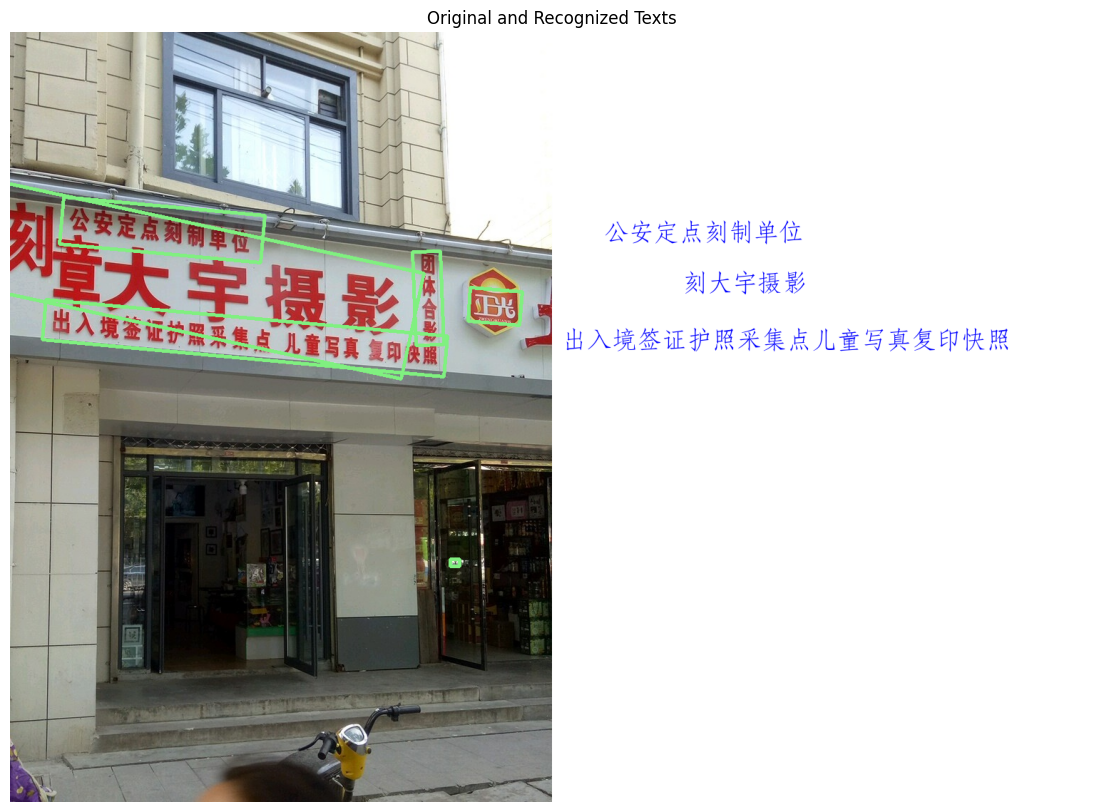

In [25]:
print(recognized_texts)
font_path="/usr/share/fonts/truetype/fangsong.ttf"
print(origin_img.shape)
white_image = np.ones(origin_img.shape, dtype=np.uint8) * 255  # create blank image
img_with_text=draw_text_on_image(white_image, recognized_texts, boxes_list,font_path, font_size=35, color=(0, 0, 255))  # Red text
combined_image = np.hstack((img_boxes, img_with_text))    # concate image
display_image(combined_image, title="Original and Recognized Texts", figsize=(15, 10))